# Book Recommendation

---------------
## **Context**
---------------

Over 3.5 billion people use the internet for a variety of reasons. Online retail sales are expected to grow steadily in the coming years. One of the most important requirements of E-commerce portals is a book recommendation for ease of reading and referencing. A book recommendation system is a type of recommendation system in which the reader is recommended similar books based on his or her interests.

Book Recommendation Systems are used by the vast majority of E-commerce businesses such as Amazon, Barnes and Noble, Flipkart, Goodreads, and other online retailers to recommend books that customers may be tempted to buy based on their preferences. This feature can assist in increasing shopping value while reducing shopping time. Logical recommendations not only assist customers in making purchases but also increase total sales value.

-----------------
## **Objective**
-----------------

Build recommendation system for the platform.

-----------------
## **Datasets**
-----------------

The **ratings** dataset contains the following attributes: 
- user-Id: Unique ID for each user
- ISBN: International Standard Book Number. Books are identified by their respective ISBN
- Book-rating: Rating for each book expressed on a scale from 1-10

The **books** dataset contains the following attributes:
- ISBN: International Standard Book Number
- Book-title: Title of the book
- Book-author: Name of the author
- Year-of-Publication: Publication Year
- Publisher: Name of the publisher of the book
- Image-Url-S: Small image of the book (Amazon link)
- Image-Url-M: Medium size image of the book (Amazon link)
- Image-Url-L: Large size image of the book (Amazon link)

The **users** dataset has following attributes:
- User_ID: Unique ID for each user
- Location: the location of the user
- Age: age of the user

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Let's install surprise library
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Basic python libraries
import numpy as np
import pandas as pd

# Python libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD
from collections import defaultdict

# For implementing cross validation
from surprise.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

## **Loading the data**

In [4]:
# Reading the datasets
book = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Book Recommendation System/Books.csv')
rating = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Book Recommendation System/Ratings.csv')
user = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Book Recommendation System/Users.csv')

## **Exploring the ratings data**

In [5]:
rating.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [6]:
book.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [7]:
user.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


**Let's merge the 'rating' and 'book' datasets and then we can choose only the columns relevant to our task.**

In [8]:
df = pd.merge(rating, book.drop_duplicates(['ISBN']), on="ISBN", how="left")
df.drop(['Image-URL-S','Image-URL-M','Image-URL-L'], axis =1, inplace = True)

df.rename(columns = {'User-ID':'user_id', 'ISBN':'book_id', "Book-Rating":"rating"}, inplace = True)
df.head()

,user_id,book_id,rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001,Heinle
2,276727,0446520802,0,The Notebook,Nicholas Sparks,1996,Warner Books
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999,Cambridge University Press
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press


In [9]:
# Let's check the info on resulting data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1149780 entries, 0 to 1149779
Data columns (total 7 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   user_id              1149780 non-null  int64 
 1   book_id              1149780 non-null  object
 2   rating               1149780 non-null  int64 
 3   Book-Title           1031136 non-null  object
 4   Book-Author          1031135 non-null  object
 5   Year-Of-Publication  1031136 non-null  object
 6   Publisher            1031134 non-null  object
dtypes: int64(2), object(5)
memory usage: 70.2+ MB


**Observations:**

- We have 7 columns with 1 149 780 entries. 
- Most of the columns are of object type, user_id and rating are int64. 
- Book title, Book_Author, Year-Of-Publication and Publisher columns have some missing values in them.  

In [10]:
# Many book_id contains combination of letters & digits. 
# So let's convert the column to type 'string'
df['book_id']= df['book_id'].astype(str)

### **Checking the distribution of ratings**

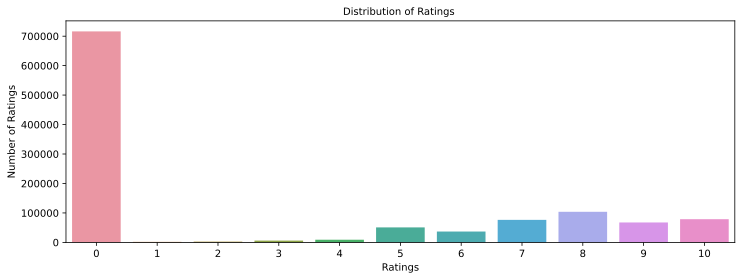

In [11]:
# Distribution of ratings
plt.figure(figsize = (12, 4))
sns.countplot(data=df, x='rating')

plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.show()

**Observations:**

- Most of the books have 0 rating, since according to the dataset description the ratings range from 1 to 10, we will consider these values as missing. 

So let's deal with 0 ratings first.  

In [12]:
# Let's drop rows with ratings equal to 0
df.drop(df.index[df['rating'] == 0], inplace = True)

In [13]:
# Let's check the info of the data after removing entries with rating = 0 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 433671 entries, 1 to 1149779
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   user_id              433671 non-null  int64 
 1   book_id              433671 non-null  object
 2   rating               433671 non-null  int64 
 3   Book-Title           383842 non-null  object
 4   Book-Author          383841 non-null  object
 5   Year-Of-Publication  383842 non-null  object
 6   Publisher            383840 non-null  object
dtypes: int64(2), object(5)
memory usage: 26.5+ MB


**Observations:**

- The size of the dataset is 433 671 entries now. 

Let's check the distribution of ratings again.

### **Checking updated distribution of ratings**

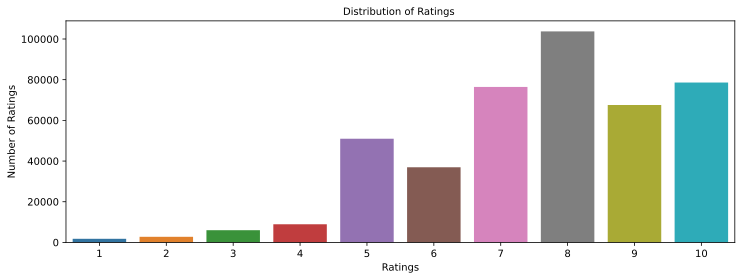

In [14]:
# Distribution of ratings
plt.figure(figsize = (12, 4))
sns.countplot(data=df, x='rating')

plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.show()

**Observations:**

- The ratings from 1 to 4 contribute to only small part of all the ratings. 
- The most popular rating is 8 followed by 10, 7 and 9 ratings.

In [15]:
# Let's check the number of unique users
df['user_id'].unique().shape[0]

77805

In [16]:
# Let's check the number of unique books
df['book_id'].unique().shape[0]

185973

**Observations:**

- There are 77805 unique users and 185973 books in the dataset, so the total number of potential interactions is 77805 x 185973 ~ 14.5B.
- We have only 433671 of observed interactions which is ~ 0.003% from total. 
This is a very sparse data. 
- Our task is predict all possible interactions which were not observed. 

**Let's check if the all observed interactions between an user and a book are unique.**

In [17]:
df.groupby(['user_id', 'book_id']).count()

rating  Book-Title  Book-Author  Year-Of-Publication  \
user_id book_id                                                            
8       0002005018       1           1            1                    1   
        074322678X       1           1            1                    1   
        0887841740       1           1            1                    1   
        1552041778       1           1            1                    1   
        1567407781       1           1            1                    1   
...                    ...         ...          ...                  ...   
278854  0375703063       1           1            1                    1   
        042516098X       1           1            1                    1   
        0425163393       1           1            1                    1   
        0553275739       1           1            1                    1   
        0553579606       1           1            1                    1   

                    Publisher  
user_id book_id                
8       0002005018          1  
        074322678X          1  
        0887841740          1  
        1552041778          1  
        1567407781          1  
...                       ...  
278854  0375703063          1  
        042516098X          1  
        0425163393          1  
        0553275739          1  
        0553579606          1  

[433671 rows x 5 columns]

In [18]:
df.groupby(['user_id', 'book_id']).count()['rating'].sum()

433671

**Observation:**
- The **sum is equal to the total number of observations**, which implies that **there is only one interaction between a book and a user**.

#### Which book has the highest number of reviews / ratings in the dataset?

In [19]:
df['Book-Title'].value_counts()

The Lovely Bones: A Novel                                  707
Wild Animus                                                581
The Da Vinci Code                                          494
The Secret Life of Bees                                    406
The Nanny Diaries: A Novel                                 393
                                                          ... 
Anti-Memoirs/207011                                          1
Mad Love (French Modernist Library)                          1
Miracle of the Rose                                          1
Doctor Sax: Faust Part Three                                 1
Perplexing Lateral Thinking Puzzles: Scholastic Edition      1
Name: Book-Title, Length: 135567, dtype: int64

**Observations:**
- The book which has the most of the interactions with users is "The Lovely Bones: A Novel". 

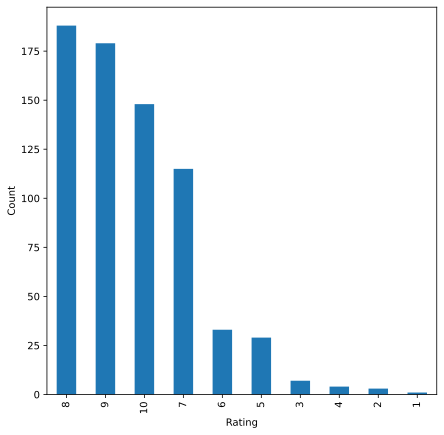

In [20]:
# Let's plot distributions of ratings for the most interacted book
plt.figure(figsize=(7,7))
df[df['Book-Title'] == 'The Lovely Bones: A Novel']['rating'].value_counts().plot(kind='bar') 
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

**Observations:**

- It follows quite closely to the observed pattern for all the books ratings. 
- Overall this book is rated very highly. The most popular rating is 8, followed by 9, 10 and 7. 
- Ratings below 7 contribute to only small fraction of all the ratings observed.  

In [21]:
# Let's check the user who interacted most
df['user_id'].value_counts()

11676     8524
98391     5802
153662    1969
189835    1906
23902     1395
          ... 
114079       1
114081       1
114096       1
114115       1
276723       1
Name: user_id, Length: 77805, dtype: int64

**Observations:**

- User 11676 interacted 8524 times. 
- But even for this user there is still lots of possible interactions to predict 185973-8524 = 177449. 
- So we observed only  ~ 4.6% of all the possible interactions on this user.  

## **Data Preparation**

As this dataset is still quite large and has 433671 observations, it is not be computationally efficient to build a model using this. Moreover, there are many users who have only rated a few books and also there are also books which are rated by very few users. Hence we can reduce the dataset by considering certain logical assumption.

Let's take the users who have given at least 50 rating, as we prefer to have some number of rating of a book and the book which has at least 10 rating, as when we shop online we prefer to have some number of rating of that product.

In [22]:
# Let's get the column containing the users
users = df.user_id
# And create a dictionary from the users to find their number of rated books
user_ratings_count = {}
for user in users:
    # If we already have the user, just add 1 to their rating count
    if user in user_ratings_count:
        user_ratings_count[user] += 1
    # Otherwise, set their rating count to 1
    else:
        user_ratings_count[user] = 1    

In [23]:
USERS_RATINGS_CUTOFF = 50
users_to_remove = [user for user, num_ratings in user_ratings_count.items()
                   if num_ratings < USERS_RATINGS_CUTOFF]
df = df.loc[~df.user_id.isin(users_to_remove)]

In [24]:
df.shape

(175023, 7)

In [25]:
# Let's get the column containing the books
books = df.book_id
# Create a dictionary from books to find their number of users
books_ratings_count = dict()
for book in books:
    # If we already have the book, just add 1 to their rating count
    if book in books_ratings_count:
        books_ratings_count[book] += 1
    # Otherwise, set their rating count to 1
    else:
        books_ratings_count[book] = 1   

In [26]:
# We want our book to be interacted by at least 10 users to be considered
BOOKS_RATINGS_CUTOFF = 10
books_to_remove = [book for book, num_ratings in books_ratings_count.items()
                   if num_ratings < BOOKS_RATINGS_CUTOFF]
df= df.loc[~df.book_id.isin(books_to_remove)]

In [27]:
df.shape

(26698, 7)

### **Distribution of the user-books interactions in the dataset**

In [28]:
df.nunique()

user_id                1257
book_id                1497
rating                   10
Book-Title             1367
Book-Author             587
Year-Of-Publication      43
Publisher               204
dtype: int64

In [29]:
# Finding user-books interactions distribution
count_interactions = df.groupby('user_id').count()['book_id']
count_interactions

user_id
254       18
638       20
643        3
1025       7
1211       3
          ..
277427    36
278026    11
278137     8
278188     9
278418     9
Name: book_id, Length: 1257, dtype: int64

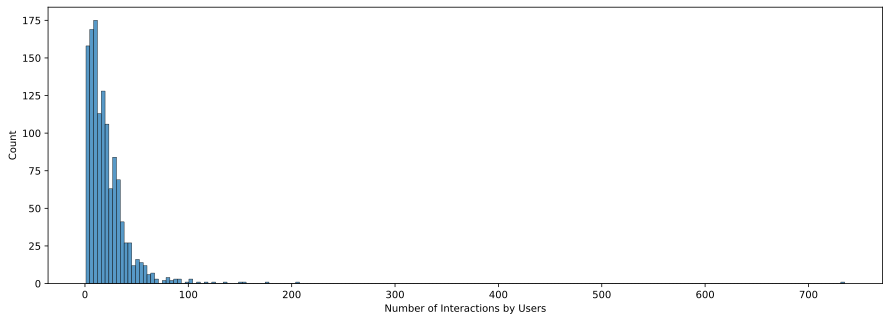

In [30]:
# Let's plot user-item interactions distribution
plt.figure(figsize=(15,5))
sns.histplot(count_interactions)
plt.xlabel('Number of Interactions by Users')
plt.show()

**Observations:**
- The distribution is highly skewed to the right. 
- Most of the obsevations are in the range of 1 - 50 interactions. 

**As we have now explored the data, let's start building Recommendation Systems**

## **Model 1: Rank-Based Recommendation System**

Let's build a simple Rank-Based Recommendation System first. 

- Rank-based recommendation systems provide recommendations based on the most popular items. This kind of recommendation system is useful when we have cold start problems. Cold start refers to the issue when we get a new user into the system and the machine is not able to recommend book to the new user, as the user did not have any historical interactions in the dataset. In those cases, we can use rank-based recommendation system to recommend book to the new user.

- To build the rank-based recommendation system, we take average of all the ratings provided to each book and then rank them based on their average rating.

In [31]:
# Let's calculate average ratings for each book_id
average_rating = df.groupby('book_id').mean()['rating']

# And the count of ratings for each book_id
count_rating = df.groupby('book_id').count()['rating']

# Let's make a dataframe with the count and average of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 
                             'rating_count':count_rating})

In [32]:
final_rating.head()

,avg_rating,rating_count
book_id,,
0020442203,8.727273,11
002542730X,7.428571,28
0028604199,8.000000,10
0060002050,7.800000,10
006000438X,7.666667,15


In [33]:
final_rating['rating_count'].value_counts()

10     237
11     196
12     161
13     114
14     104
      ... 
70       1
47       1
77       1
145      1
68       1
Name: rating_count, Length: 65, dtype: int64

Now, let's create a function to find the **top n books** for a recommendation based on the average ratings of books. We can also add a **threshold for a minimum number of interactions** for a book to be considered for recommendation. 

In [34]:
def top_n_books(data, n, min_interactions=100):
    
    # Finding books with minimum number of interactions
    recommendations = data[data['rating_count'] > min_interactions]
    
    # Sorting values w.r.t. average rating 
    recommendations = recommendations.sort_values('avg_rating', ascending=False)

    return recommendations.index[:n]

We can **use this function with different n's and minimum interactions** to get books to recommend.

##### **Recommending top 5 Books with 10 minimum interactions based on popularity**

In [35]:
res = list(top_n_books(final_rating, 5, 10))
# Name of the books
list_of_books = []
for i in res:
    list_of_books.append(df[df['book_id'] == str(i)]['Book-Title'].unique()[0])
list_of_books

['The Two Towers (The Lord of the Rings, Part 2)',
 'Harry Potter and the Chamber of Secrets Postcard Book',
 "My Sister's Keeper : A Novel (Picoult, Jodi)",
 'The Giving Tree',
 'A Tree Grows in Brooklyn']

##### Recommending top 5 Books with 50 minimum interactions based on popularity

In [36]:
res2 = list(top_n_books(final_rating,5,50))
# Name of the books
list_of_books = []
for i in res2:
    list_of_books.append(df[df['book_id'] == str(i)]['Book-Title'].unique()[0])
list_of_books

['Harry Potter and the Goblet of Fire (Book 4)',
 'Harry Potter and the Prisoner of Azkaban (Book 3)',
 'To Kill a Mockingbird',
 "Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))",
 'Harry Potter and the Order of the Phoenix (Book 5)']

## **Model 2: Collaborative Filtering Based Recommendation System**

Let's build a similarity-based recommendation system using cosine similarity and using KNN to find similar users who are the nearest neighbor to the given user.

In [37]:
# Let's import necessary libraries

# Data preparation
from surprise.reader import Reader
from surprise.dataset import Dataset
from surprise.model_selection import train_test_split

# Prediction
from surprise.prediction_algorithms.knns import KNNBasic

# Hyperparameters fine-tuning
from surprise.model_selection import GridSearchCV

# Metrics 
from surprise import accuracy

### **Used terminology description:**

**Relevant item** - An item (book in this case) that is actually **rated higher than the threshold rating (here 7)** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item** - An item that's **predicted rating is higher than the threshold (here 7) is a recommended item**, if the **predicted rating is below the threshold then that book will not be recommended to the user**.  


**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. Value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-Score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them. 

Let's build a function that takes the **recommendation model** as input and gives the **precision@k and recall@k** for that model.

In [38]:
def precision_recall_at_k(model, k=10, threshold=7):

    # First map the predictions to each user
    user_est_true = defaultdict(list)
    
    # Making predictions on the test data
    predictions=model.test(testset)
    
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set Precision to 0 when n_rec_k is 0.
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set Recall to 0 when n_rel is 0.
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    
    # Mean of all the predicted precisions.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)),3)
    # Mean of all the predicted recalls.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)),3)
    # Root Mean Squared Error
    accuracy.rmse(predictions)
    print('Precision: ', precision) 
    print('Recall: ', recall) 
    print('F_1 score: ', round((2*precision*recall)/(precision+recall),3))

**Let's encode the user_id and book_id for simplicity.**

In [39]:
from sklearn.preprocessing import LabelEncoder
data=df[['user_id','book_id']].apply(LabelEncoder().fit_transform)
data['rating']=df['rating']
data.head()

,user_id,book_id,rating
1211,1251,521,9
1213,1251,524,9
1214,1251,525,8
1456,1252,1,10
1474,1252,52,9


In [40]:
# Let's create a copy of the above dataset for further use
df_rating = data.copy()

In [41]:
# Calculating average ratings
average_rating = df_rating.groupby('book_id').mean()['rating']

# Calculating the count of ratings
rating_count = df_rating.groupby('book_id').count()['rating']
# Updating the final_rating dataframe with the new encoded book_id count
# and average of ratings based on the new dataframe
final_rating = pd.DataFrame({'avg_rating':average_rating,
                             'rating_count':rating_count})
final_rating.head()

,avg_rating,rating_count
book_id,,
0,8.727273,11
1,7.428571,28
2,8.000000,10
3,7.800000,10
4,7.666667,15


Let's load the `data` dataset into `surprise.dataset.DatasetAutoFolds` format which is required for this library.

**Making the dataset into surprise dataset and splitting it into train and test set**

In [42]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 10))

# Loading the rating dataset
data = Dataset.load_from_df(df_rating[['user_id', 'book_id', 'rating']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.3, random_state=42)

### **User-Based Collaborative Filtering Recommendation System**

In [43]:
# Let's define similarity options
sim_options = {'name': 'cosine',
              'user_based':True}

algo_knn_user = KNNBasic(sim_options=sim_options, verbose=False)

# Fitting the trainset
algo_knn_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k =10 and threshold=7.
precision_recall_at_k(algo_knn_user)

RMSE: 1.8455
Precision:  0.816
Recall:  0.812
F_1 score:  0.814


**Observations:**

-  We get very decent and balanced Precision and Recall and as the result F1 Score on the test dataset.

### **Improving similarity based recommendation system by tuning its hyperparameters**

Hyperparameters for KNN_Basic to tune.

- **k** (int) – The (max) number of neighbors to take into account for aggregation (see this note). Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise - 
    - cosine
    - msd (default)
    - pearson
    - pearson baseline

In [44]:
# Let's set up the parameter grid for tuning
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine','pearson','pearson_baseline'],
                              'user_based': [True]}
              }

# And perform 3-fold cross validation
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.705247310886887
{'k': 20, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': True}}


Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [45]:
# Using the optimal similarity measure for user-based collaborative filtering
sim_options = {'name': 'msd','user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized = KNNBasic(sim_options=sim_options,
                                      k=20,
                                      min_k=6,
                                      verbose=False)

# Training the algorithm on the train set
similarity_algo_optimized.fit(trainset)

# Let us compute precision@k and recall@k with k=10.
precision_recall_at_k(similarity_algo_optimized)

RMSE: 1.6866
Precision:  0.834
Recall:  0.891
F_1 score:  0.862


**Observations:**

- We managed to sufficiently improve all the metrics.
- At the same time there is some disbalance between the Precision and Recall.

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Let's build a function to implement the Optimized KNNBasic Algoritm. The parameters are:

- data: a rating dataset
- user_id:  user_id against which we want the recommendations
- top_n: the number of items we want to recommend
- algo: the algorithm we want to use to predict the ratings
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [46]:
def get_recommendations(data, user_id, top_n, algo):
    
    # An empty list to store the recommended book ids
    recommendations = []
    
    #  User item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='user_id', columns='book_id', values='rating')
    
    # Extracting those book ids which the user_id has not interacted with yet
    non_interacted_items = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the book id which user_id has not interacted with yet
    for book_id in non_interacted_items:
        
        # Predicting the ratings for those non interacted book ids by this user
        est = algo.predict(user_id, book_id).est
        
        # Appending the predicted ratings
        recommendations.append((book_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # Returning top n predicted rating items for this user

In [47]:
df_rating=df_rating.drop_duplicates()

**Let's predict the top 5 items for userId=1 using the user similarity-based recommendation system built.**

In [48]:
recommendations = get_recommendations(df_rating,1, 5,similarity_algo_optimized)

In [49]:
# Building the dataframe for above recommendations with columns "book_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['book_Id', 'predicted_ratings'])

,book_Id,predicted_ratings
0,259,10.000000
1,1297,9.884446
2,658,9.870802
3,639,9.764398
4,451,9.702661


### **Correcting the Ratings and Ranking of the above books**

While comparing the ratings of two books, it is not only the **ratings** that describe the **likelihood of the user to that book**. Along with the rating the **number of users who have read that book** also becomes a important point to consider. So let's calculate the **"corrected_ratings"** for each book. Commonly higher the **"rating_count" of a book more reliable the rating is**. To interpret the above concept, a **book rated 8 with rating_count 5 is less liked in comparison to a book rated 7 with a rating count of 50**. It has been **empirically found that the likelihood of the book can be corrected by adding of subtracting the inverse of the square root of the rating_count of the book**.

In [50]:
# Let's build a function to correct ratings
def ranking_books(recommendations, final_rating):
  # Sort the books based on ratings count
  ranked_books = final_rating.loc[[items[0] for items in recommendations]].sort_values('rating_count', ascending=False)[['rating_count']].reset_index()

  # Merge with the recommended books to get predicted ratings
  ranked_books = ranked_books.merge(pd.DataFrame(recommendations, columns=['book_id', 'predicted_ratings']), on='book_id', how='inner')

  # Rank the books based on corrected ratings
  ranked_books['corrected_ratings'] = ranked_books['predicted_ratings'] - 1 / np.sqrt(ranked_books['rating_count'])

  # Sort the books based on corrected ratings
  ranked_books = ranked_books.sort_values('corrected_ratings', ascending=False)
  
  return ranked_books

**Note:** In the **above-corrected rating formula**, we can add the **quantity `1/np.sqrt(n)` instead of subtracting it to get more optimistic predictions**. But here we are **subtracting this quantity**, as there are some books with ratings 10 and **we can't have a rating more than 10 for a book**.

In [51]:
# Applying the ranking_books function and sorting it based on corrected ratings
ranking_books(recommendations, final_rating)

,book_id,rating_count,predicted_ratings,corrected_ratings
3,259,31,10.000000,9.820395
0,658,53,9.870802,9.733441
2,1297,35,9.884446,9.715415
1,639,43,9.764398,9.611899
4,451,18,9.702661,9.466959


### **Model 3: Item based Collaborative Filtering Recommendation System**

* We built **user-user similarity-based collaborative filtering**. Now, let's look into item-item similarity-based collaborative filtering. 

In [52]:
# Defining similarity measure
sim_options = {'name': 'cosine',
               'user_based': False}

# Defining nearest neighbour algorithm
algo_knn_item = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the train set 
algo_knn_item.fit(trainset)

# Let's compute the precision@k, recall@k, and f_1 score with k=10
precision_recall_at_k(algo_knn_item)

RMSE: 1.6210
Precision:  0.802
Recall:  0.8
F_1 score:  0.801


**Observations:**

- The RMSE is lower on the testset compared to the same algoritm based built on user-user similarity. 
- At the same time Presicion, Recall and F_1 score are a bit lower, but still very balanced.

**Let's tune the hyperparameters of the model.**

In [53]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20,30,40], 'min_k': [3,6,9],
              'sim_options': {'name': ['msd','cosine','pearson','pearson_baseline'],
                              'user_based':[False]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic,param_grid,measures=['rmse'],cv=3,n_jobs=-1)

# Fitting the data
grid_obj.fit(data)

# Best RMSE score
print(grid_obj.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

1.5950520510905648
{'k': 40, 'min_k': 3, 'sim_options': {'name': 'cosine', 'user_based': False}}


Now, let's build the **final model** by using **optimal values of the hyperparameters** which we received by using grid search cross-validation.

In [54]:
# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_item = KNNBasic(k=40,
                                          min_k=3,
                                          sim_options={'name': 'cosine',
                                                       'user_based': False},
                                          verbose=False)

# Training the algorithm on the train set
similarity_algo_optimized_item.fit(trainset)

# Let us compute precision@k and recall@k with k=10
precision_recall_at_k(similarity_algo_optimized_item)

RMSE: 1.5872
Precision:  0.818
Recall:  0.836
F_1 score:  0.827


**Observations:**

- We managed to improve all the metrics on the testset
- Precision and Recall are still quite balanced 
- At the same time overall performance is lower than we managed to achieve with user-user colaborative filtering.

#### Predicted top 5 books for user_id=1 with the item similarity based recommendation system built.

In [55]:
recommendations = get_recommendations(df_rating,1, 5,similarity_algo_optimized_item)

In [56]:
# Building the dataframe for above recommendations with columns "book_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['book_Id', 'predicted_ratings'])

,book_Id,predicted_ratings
0,1,10
1,15,10
2,16,10
3,17,10
4,30,10


In [57]:
# Corrected ratings
ranking_books(recommendations, final_rating)

,book_id,rating_count,predicted_ratings,corrected_ratings
0,1,28,10,9.811018
1,15,13,10,9.722650
2,16,13,10,9.722650
3,17,12,10,9.711325
4,30,10,10,9.683772


## **Model 4: Matrix Factorization**

**Let's build a model based on SVD to used so-called personalized clustering approach with latent features.**

#### **Building a baseline matrix factorization recommendation system**

In [60]:
# SVD matrix factorization
svd = SVD(random_state=1)

# Training the algorithm on the train set
svd.fit(trainset)

# Let's compute precision@k and recall@k with k=10
precision_recall_at_k(svd)

RMSE: 1.5106
Precision:  0.827
Recall:  0.86
F_1 score:  0.843


**Observations:**

- The svd approach shows the best results so far. 
- The Precision and Recall are quite balanced. 

### **Improving matrix factorization based recommendation system by tuning its hyperparameters**

In SVD, rating is predicted as: 

$$\hat{r}_{u i}=\mu+b_{u}+b_{i}+q_{i}^{T} p_{u}$$

If user $u$ is unknown, then the bias $b_{u}$ and the factors $p_{u}$ are assumed to be zero. The same applies for item $i$ with $b_{i}$ and $q_{i}$.

To estimate all the unknown, we minimize the following regularized squared error:

$$\sum_{r_{u i} \in R_{\text {train }}}\left(r_{u i}-\hat{r}_{u i}\right)^{2}+\lambda\left(b_{i}^{2}+b_{u}^{2}+\left\|q_{i}\right\|^{2}+\left\|p_{u}\right\|^{2}\right)$$

The minimization is performed by a very straightforward **stochastic gradient descent**:

$$\begin{aligned} b_{u} & \leftarrow b_{u}+\gamma\left(e_{u i}-\lambda b_{u}\right) \\ b_{i} & \leftarrow b_{i}+\gamma\left(e_{u i}-\lambda b_{i}\right) \\ p_{u} & \leftarrow p_{u}+\gamma\left(e_{u i} \cdot q_{i}-\lambda p_{u}\right) \\ q_{i} & \leftarrow q_{i}+\gamma\left(e_{u i} \cdot p_{u}-\lambda q_{i}\right) \end{aligned}$$

Let's try to fine-tune these hyperparameters:

- **n_factors**: The number of factors used for SVD
- **biased (bool)**: Whether to use baselines (or biases).
- **n_epochs**: The number of iteration of the SGD algorithm
- **lr_all**: The learning rate for all parameters
- **reg_all**: The regularization term for all parameters

In [62]:
# Set the parameter space to tune
param_grid = {'n_factors' : [80,90,100,120,140,160,180,200],
              'biased' : [True,False],
              'n_epochs': [10,20,30],
              'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross validation
gs_ = GridSearchCV(SVD,
                   param_grid,measures=['rmse'],
                   return_train_measures=True,
                   cv=3,
                   n_jobs=-1)

# Fitting data
gs_.fit(data)

# Best RMSE score
print(gs_.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_.best_params['rmse'])

1.505641086120077
{'n_factors': 80, 'biased': True, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.2}


Now, let's **build the final model** by using **optimal values** of the hyperparameters which we received by using grid search cross-validation.

In [63]:
# Building the optimized SVD modelh
svd_optimized = SVD(n_factors=80,
                    biased=True,
                    n_epochs=30,
                    lr_all=0.005,
                    reg_all=0.2)

# Training the algorithm on the train set
svd_optimized=svd_optimized.fit(trainset)

# Let us compute precision@k and recall@k with k=10
precision_recall_at_k(svd_optimized)

RMSE: 1.5000
Precision:  0.828
Recall:  0.855
F_1 score:  0.841


**Observations:**
- We managed to slightly improve the model performance. 

**Now, let's recommend the books using the optimized svd model**

In [64]:
# Getting top 5 recommendations for user_id 1 using "svd_optimized" algorithm.
svd_recommendations = get_recommendations(df_rating, 1, 5, svd_optimized)

In [65]:
# Ranking book based on above recommendations.
ranking_books(svd_recommendations, final_rating)

,book_id,rating_count,predicted_ratings,corrected_ratings
0,102,16,10,9.750000
1,73,14,10,9.732739
2,17,12,10,9.711325
3,34,12,10,9.711325
4,84,10,10,9.683772


## **Conclusions:**

- The best performance was achieved with optimised KNNBasic model based on user-user similarities, F1 Score = 86.2%
- Matrix Factorization has lower RMSE (1.50 vs 1.6866) because this method assumes that both books and users are present in some low dimensional latent space describing their properties and recommends a book based on its proximity to the user in the latent space.
- We recommend to use optimised KNNBasic model at this stage as it gives the best results. 

## **Future Development:**

For future development we propose to consider hybrid recommendation system as it has potential to push the performance even further. 